# Tutorial

## Part 1: clustering microbiome samples

> Note: This tutorial uses the latest release of HULK (0.1.0).

***

Let's walk through a basic use case for HULK:

* We have a bunch of existing microbiome samples and we want to compare some new samples against these, pulling out similar samples from our collection and then do some cool science with them.

One way to do this is using a search index. We want this index to give us microbiome samples that are similar to our query. For example, if I had an oral microbiome sample, I would expect this search index to give me predominantly oral microbiome samples back. This expectation is due to the fact that we know that different body sites have distinct microbiota compositions.

First things first, can HULK give us histosketches that differentiate between microbiome samples? (spoiler: yes, but keep going with the tutorial...)

In part one of the tutorial, we'll be using HULK to generate histosketches of mock human microbiome samples that are derived from different body sites. We'll then use the histosketches to cluster the samples and see if the HULK histosketches carry enough of a signature to differentiate between microbiome samples from different body sites.

We'll be using the [CAMI](https://data.cami-challenge.org) simulated Illumina HiSeq metagenome data set. This contains 49 mock microbiome samples (10 GI tract, 10 oral cavity, 10 airways, 10 skin, 9 urogenital tract). This is the info that CAMI gives us on these samples:

| libraries | basepairs (bp) |
| :--- | :--- |
|Total size| 245 Gbp|
|Read length| 2x150 bp|
|Insert size mean| 270 bp|
|Insert size s.d.| 20 bp|

### Get the data

Although HULK is designed for working on data streams, for the purpose of this tutorial we will download the data first so that we can try a few different things out.

I wrote a bash snippet that can grab all the CAMI data and store it by body site:

```bash
#!/usr/bin/env bash

SAMPLES=( "Airways" "Gastrointestinal_tract" "Oral" "Skin" "Urogenital_tract" )

for sample in "${SAMPLES[@]}"
    do
    mkdir ${sample} && cd $_
    echo "downloading the ${sample} read data from CAMI"
    URL="https://openstack.cebitec.uni-bielefeld.de:8080/swift/v1/CAMI_${sample}/"
    echo "url: ${URL}"

    # get the file list
    curl -s ${URL} | grep "short_read.*fq.gz" >> reads.list

    # download each file in turn and store in sequentially labelled fastqs
    COUNTER=1
    while read -r line
        do
        download=${URL}${line}
        curl -s ${download} -o ${COUNTER}.fastq.gz
        COUNTER=$((COUNTER + 1))
        echo "downloaded ${download} and saved to ${COUNTER}.fastq.gz"
        done < reads.list
    rm reads.list
    cd ..
    done
echo "finished."
```

To make sure all the regexes etc. work from now on, make sure you have a directory structure like this:

```
$ pwd

/home/hulk-analysis

$ ls -l

Airways
Gastrointestinal_tract
Oral
Skin
Urogenital_tract
```

So, we now have the raw data and it is organised according to body site.


### Running HULK

To begin with, let's use a fairly long k-mer and see if we can cluster the data easily. I'll show the basic command, break it down and then give you a script to run all of the jobs quickly.

* Before we go any further though, make sure you have HULK version 0.1.0 installed:

```
$ hulk version
```

* Now here is the HULK command to sketch a single sample:

```
$ gunzip -c Airways/1.fastq.gz | hulk sketch -p 8 -k 21 -m 3 -c 10 -s 1024 -o Airways.1
```

* The bit before the pipe (`|`) is just streaming the data into the HULK command. The HULK command is using the sketch subcommand (`hulk sketch`), which is used to generate a histosketch from the datastream. Let's break down the HULK sketch subcommand to see what the flags are doing doing:

| flag | value | meaning |
| :--- | :---- | :------ |
| -p | 8 | use 8 processors for sketching |
| -k | 21 | use a k-mer size of 21 nucleotides |
| -m | 3 | ignore k-mer counts < 3 |
| -c | 10 | allocate each countmin sketch 10MB of memory |
| -s | 1024 | keep 1024 elements in the histosketch |
| -o | Airways.1 | this is the name to give the histosketch file |

* The above will generate a single histosketch from a single file, which is what we want. But we need to do this for all 49 samples. You could do a loop if you are on your laptop and it shouldn't take too long (around 2mins per histosketch), but it would be faster to use a server or HPC. If using a server, try `gnu parallel` or `rush` etc. If using HPC, here is an example LSF submission script:

```bash
#!/usr/bin/env bash

# PARAMETERS
## general
CPU=8
QUEUE=scafellpikeSKL
WALL=0:19
SAMPLES=( "Airways" "Gastrointestinal_tract" "Oral" "Skin" "Urogenital_tract" )
## hulk
K=21
M=3
C=10
S=1024

# JOB SUBMISSION
mkdir histosketches-k${K}-m${M}-c${C}-s${S} && cd $_
counter=1
for i in {1..10}
  do
  for name in "${SAMPLES[@]}"
    do
    outfile=${name}.${i}
    CMD="gunzip -c ../${name}/${i}.fastq.gz | hulk sketch -p ${CPU} -s ${S} -k ${K} -m ${M} -c ${C} -o ${outfile}"
    echo $CMD | bsub -n ${CPU} -R "span[ptile=${CPU}]" -W ${WALL} -q ${QUEUE}
  done
done
```

* Now, you should have a new directory that contains all of the histosketches:

```
$ ls ./histosketches-k21-m3-c10-s1024

Airways.11.log
Airways.11.sketch
Airways.12.log
Airways.12.sketch
...
```

* To get these histosketches ready for clustering, we need `hulk smash`!

```
$ hulk smash --wjsMatrix -d ./histosketches-k21-m3-c10-s1024/ -o cami-histosketches-k21
```

* You will now have a pairwise comparison matrix that gives us the weighted Jaccard similarities between all of our histosketches (`cami-histosketches-k21.wjs-matrix.csv`).


### Clustering

I'm running the Python code for this tutorial in a Notebook (found [here]()). You can start one for yourself (`jupyter notebook`) or do it however you prefer!


In [1470]:
# Begin by getting the libraries imported
## Pandas for managing datasets
import pandas as pd

## Re for cleaning up data headers
import re
/
## Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

## Seaborn for plotting and styling
import seaborn as sns
sns.set()

In [1471]:
# Read in the HULK weighted jaccard similarity matrix
df = pd.read_csv('cami-histosketches-k21.wjs-matrix.csv')

In [1472]:
# Rename columns to just keep the body site id
df = df.rename(columns=lambda x: re.sub('.\d+.sketch','',x))
df = df.rename(columns=lambda x: re.sub('histosketches-k21-m3-c10-s1024/','',x))
df.head()

,Oral,Oral,Gastrointestinal_tract,Oral,Gastrointestinal_tract,Gastrointestinal_tract,Gastrointestinal_tract,Oral,Oral,Oral,...,Urogenital_tract,Gastrointestinal_tract,Oral,Skin,Airways,Gastrointestinal_tract,Skin,Urogenital_tract,Airways,Skin
0,100.00,64.35,59.40,64.53,60.06,58.04,60.50,63.65,66.80,67.08,...,54.68,60.44,55.76,49.97,59.01,59.51,54.47,50.17,52.94,43.92
1,64.35,100.00,55.43,66.57,56.88,54.09,56.53,62.46,61.66,67.38,...,51.80,55.88,56.72,46.87,55.99,56.50,50.54,47.15,50.33,42.55
2,59.40,55.43,100.00,52.18,63.03,64.03,64.35,55.61,59.86,55.61,...,54.26,63.02,50.28,50.04,57.95,65.69,52.39,49.22,51.92,44.34
3,64.53,66.57,52.18,100.00,55.19,51.84,55.01,61.62,60.19,64.63,...,51.27,55.32,57.30,45.30,53.11,54.64,49.69,45.82,48.11,41.06
4,60.06,56.88,63.03,55.19,100.00,60.30,64.85,55.73,63.20,58.08,...,55.51,64.42,51.77,51.11,60.56,62.75,53.19,52.55,54.15,44.82


In [1473]:
# Check number of samples for each body site (there should be 10 each, apart from UGT with 9)
df.columns.value_counts()

Skin                      10
Gastrointestinal_tract    10
Oral                      10
Airways                    9
Urogenital_tract           8
dtype: int64

In [1474]:
# Get the body site labels
sites = pd.Series(df.columns)

In [1475]:
# Create a palette to identify the body sites
sites_pal = sns.color_palette("husl", len(sites.unique()))

In [1476]:
# Create a lookup table to link palette to body site
lut = dict(zip(sites.unique(), sites_pal))

In [1477]:
# Convert the palette to vectors that will be drawn on the side of the dataframe
colours = sites.map(lut)

Text(0.5,0.98,'histosketches of CAMI microbiome samples (k21), clustered by weighted jaccard similarity')

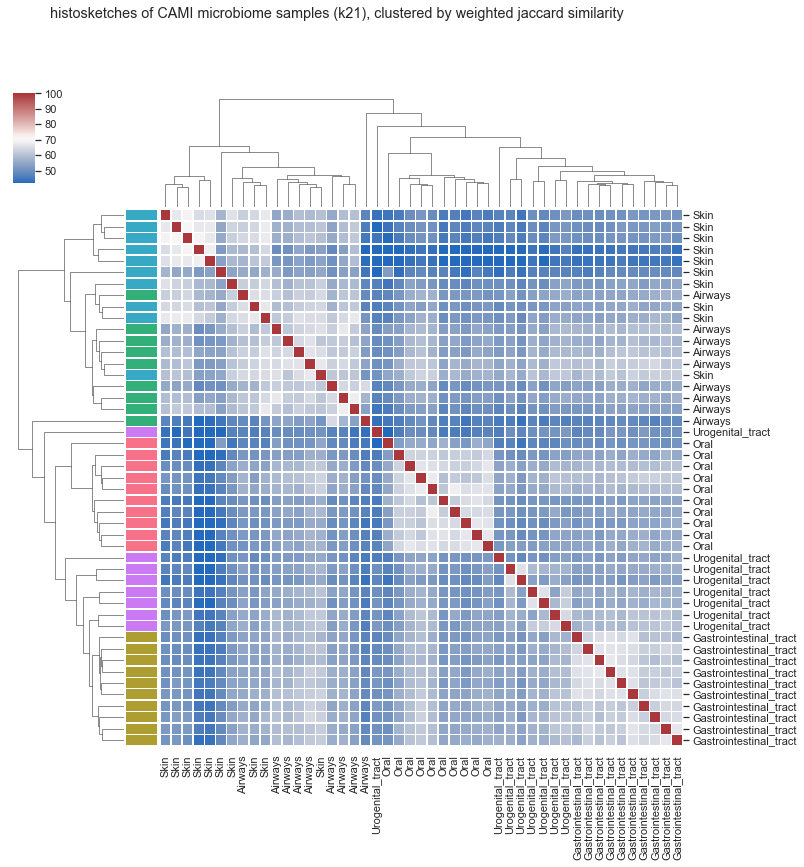

In [1482]:
# Plot the clustermap (clustering method = weighted)
g = sns.clustermap(df, method='weighted', metric='cosine', cmap="vlag",
                   row_colors=colours, row_cluster=True, col_cluster=True, yticklabels=df.columns,
                   robust=True, linewidths=.50, figsize=(12, 12))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.suptitle("histosketches of CAMI microbiome samples (k21), clustered by weighted jaccard similarity")

### Interpretation

So, the plot above shows us that HULK can be used to differentiate these samples by body site. Here are a few points about the plot:

* The weighted jaccard similarity range is between 100% and ~50%, as shown by the bar in the top left corner. So even the most dissimilar samples still share around half of the same histosketch elements with other samples.

* The dendrogram down the left side of the plot is labelled by body site, making it easier to spot groupings. We can see that there are 5 distinct clades to the dendrogram, and that these are made up (predominantly) from samples from the same body site.

* There is one histosketch that is in the wrong clade (looking at you skin sample), and there is also a urogenital tract sample that doesn't seem to be similar to anything else. These misplacements are likely because these samples are very similar and actually we don't retain enough information in the histosketch to differentiate between them. That being said, they are still grouped in the dendrogram pretty near to where they should be.

On the whole, this isn't bad. We have generated histosketches from each sample in ~2 minutes, made a weighted jaccard similarity matrix and then clustered these distances using Python. We then get a pretty heatmap, ultimately showing us that:

 >dimensionality reduction using HULK histosketches provides a signal that can be used to differentiate samples based on body site
 
Not bad, considering each sketch is only a set of 1024 integers (~10000 bytes).

But, is this enough for our indexing (because that was the aim of this after all)? Probably. But, as you can see from heatmap, even though there is a signal and we can cluster these samples, they are still all pretty similar (similarity range = 50%:100%). This means a search index using these sketches would probably give us a fair few false positives...

Don't worry! Let's use a smaller k-mer and see if we can get a better signal from these histosketches which will allow us to make a good search index. 

* Re-run the HULK sketch command but this time use a smaller k and sketch size (k=11, s=512).

* Once we've got a new matrix, have a look at the clustering. I'll cram this all into a single jupyer cell to save some space:

Text(0.5,0.98,'histosketches of CAMI microbiome samples (k11), clustered by weighted jaccard similarity')

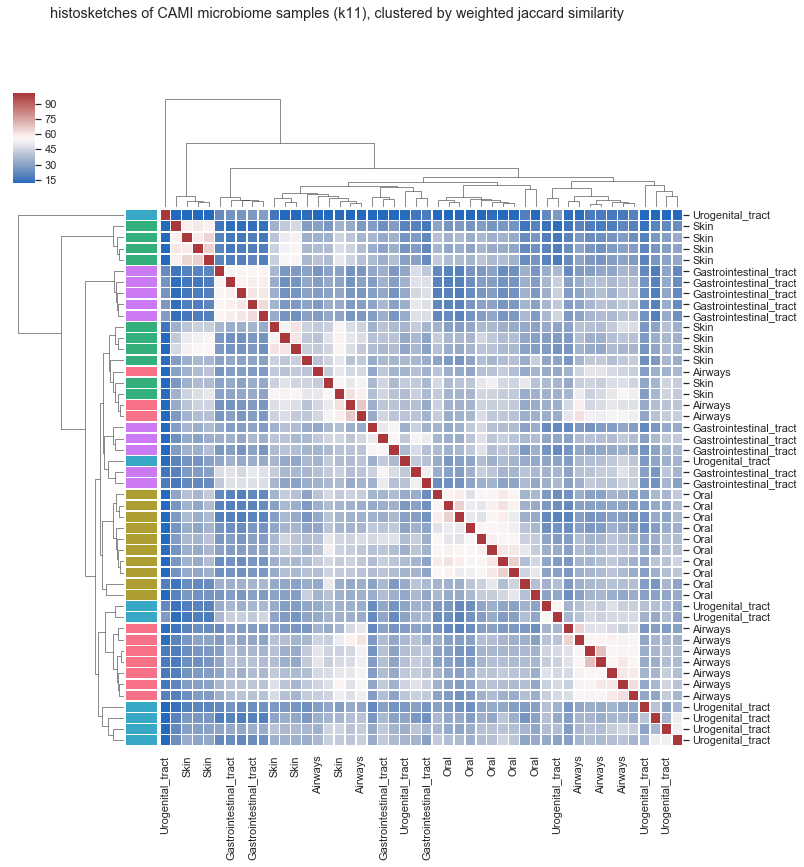

In [1485]:
# Read in the HULK weighted jaccard similarity matrix
df = pd.read_csv('cami-histosketches-k11.wjs-matrix.csv')
# Rename columns to just keep the body site id
df = df.rename(columns=lambda x: re.sub('.\d+.sketch','',x))
df = df.rename(columns=lambda x: re.sub('histosketches-k11-m1-c10-s256/','',x))
# Get the body site labels
sites = pd.Series(df.columns)
# Create a palette to identify the body sites
sites_pal = sns.color_palette("husl", len(sites.unique()))
# Create a lookup table to link palette to body site
lut = dict(zip(sites.unique(), sites_pal))
# Convert the palette to vectors that will be drawn on the side of the dataframe
colours = sites.map(lut)
# Plot the clustermap (clustering method = weighted)
g = sns.clustermap(df, method='weighted', metric='cosine', cmap="vlag",
                   row_colors=colours, row_cluster=True, col_cluster=True, yticklabels=df.columns,
                   robust=True, linewidths=.50, figsize=(12, 12))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.suptitle("histosketches of CAMI microbiome samples (k11), clustered by weighted jaccard similarity")

### Interpretation

So, we've used a smaller k, a shorter sketch and we also did not apply a theshold to the number of observed k-mers (`-m`). What we now have is a heatmap with more clades, but these clades contain samples that are clustered more tightly.

* The similarity range is greater (now 100%:15%) than the previous heatmap (100%:50%)

* We also have the samples clustering more tightly; which you can tell from the redder cells and the fact that the branch lengths within dendrogram clades are shorter than last time.

Go to the [next part]() of the tutorial to see how we can index our latest histosketches. 